# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

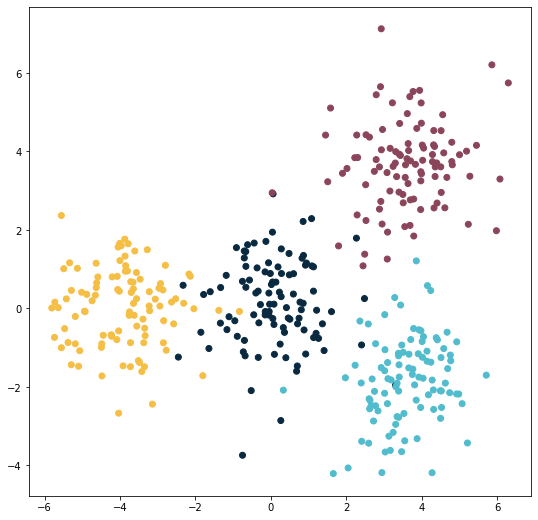

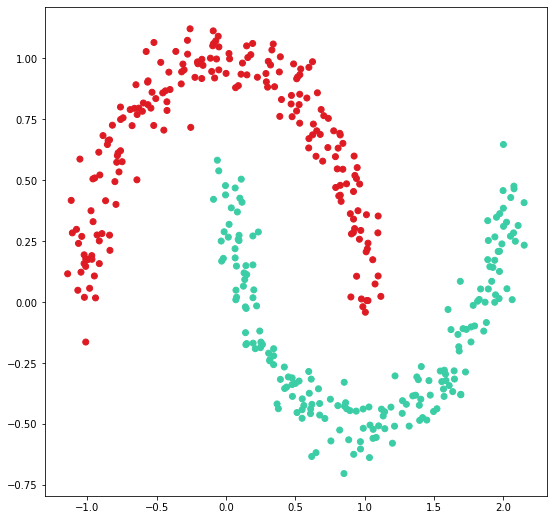

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
        """
        
        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются 
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.
        
        """
        
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter 
        
        
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.
        
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать 
            параметры X и y, даже если y не используется).
        
        """
        
        if self.init == 'random':
            self.centroids = [None] * self.n_clusters
            mins = X.min(axis=0)
            maxs = X.max(axis=0)
            for i in range(self.n_clusters):
                random_point = [np.random.uniform(mins[j], maxs[j]) for j in range(X.shape[1])] 
                self.centroids[i] = np.array(random_point)
                
        elif self.init == 'sample':
            self.centroids = X[np.random.choice(X.shape[0], n_clusters, replace=False)]
    
        else:        
            self.centroids = [None] * self.n_clusters
            self.centroids[0] = X[np.random.choice(X.shape[0])]
            dists = np.linalg.norm(X-self.centroids[0], axis=1)**2
            dists = dists[np.newaxis]
            for i in range(1, self.n_clusters):
                max_dists = dists.max(axis=0)
                random_hit = np.random.rand() * max_dists.sum()
                sum_ = 0; j = 0
                while sum_ < random_hit:
                    sum_ += max_dists[j]
                    j +=1
                self.centroids[i] = X[j-1]
                dists_to_centroid = np.linalg.norm(X-self.centroids[i], axis=1)**2
                dists = np.append(dists, dists_to_centroid[np.newaxis], axis=0)
                
        for it in range(self.max_iter):
            dists = [np.linalg.norm(X - self.centroids[i], axis=1) for i in range(self.n_clusters)]
            dists = np.array(dists)
            X_class = dists.argmin(axis=0)
            
            
            for i in range(self.n_clusters):
                self.centroids[i] = X[X_class==i].sum(axis=0)/(X_class==i).sum()
        
#         Если обнаружился пустой кластер, перекластеризуем:
        for i in range(self.n_clusters):
            if (X_class==i).sum() == 0:
                self.fit(X)
                break
            
        
    def predict(self, X: np.array) -> np.array:
        """
        Для каждого элемента из X возвращает номер кластера, 
        к которому относится данный элемент.
        
        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.
        
        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров 
            (по одному индексу для каждого элемента из X).
        
        """
        
        dists = [np.linalg.norm(X - self.centroids[i], axis=1) for i in range(self.n_clusters)]
        dists = np.array(dists)
        X_class = dists.argmin(axis=0)
        return X_class

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

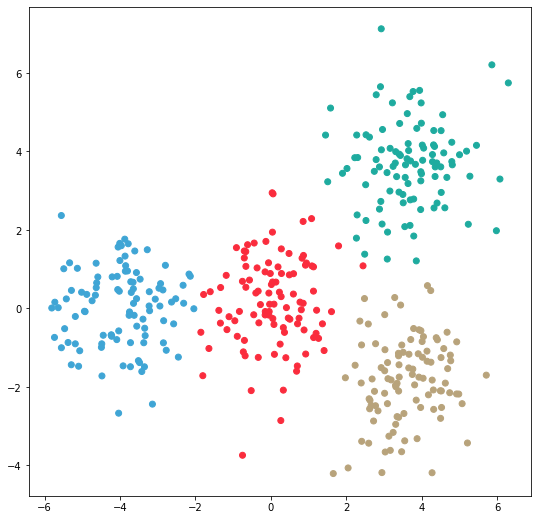

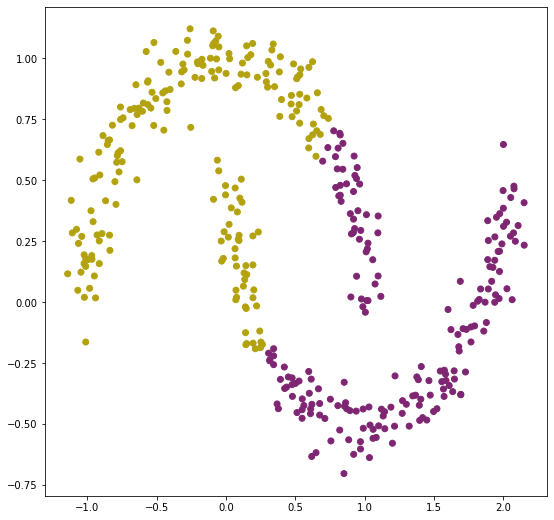

In [6]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [7]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
        """
        
        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть 
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean 
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        
        
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        tree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)

        neighbors = tree.query_radius(X, r=self.eps)
        neighbors_amnt = np.array([n.shape[0]-1 for n in neighbors])

        ind = np.arange(len(X))
        dense_ind = ind[neighbors_amnt >= self.min_samples]

        def dfs(v, color):
            X_class[v] = color
            if neighbors_amnt[v] >= self.min_samples: # значит v - плотная точка
                for u in neighbors[v]:
                    if u != v and X_class[u] == None:
                        dfs(u, color)

        X_class = [None] * len(X)
        cur_class = 0
        for i in dense_ind:
            if X_class[i] != None:
                continue
            dfs(i, cur_class)
            cur_class +=1

        X_class = np.array(X_class)
        X_class[X_class==None] = cur_class     # выбросы
        
        return X_class

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

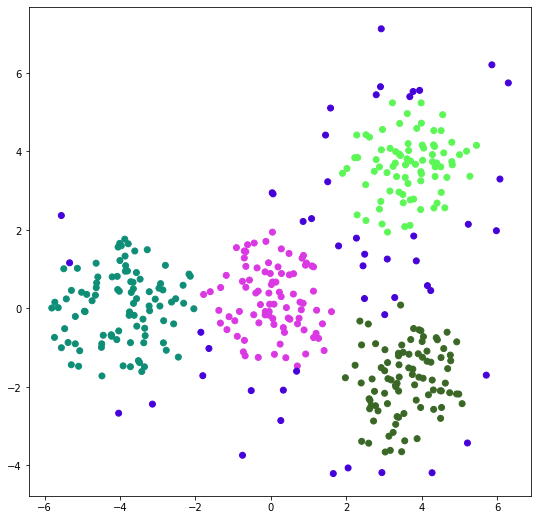

In [9]:
dbscan = DBScan(metric='chebyshev', eps=0.65, min_samples=10)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

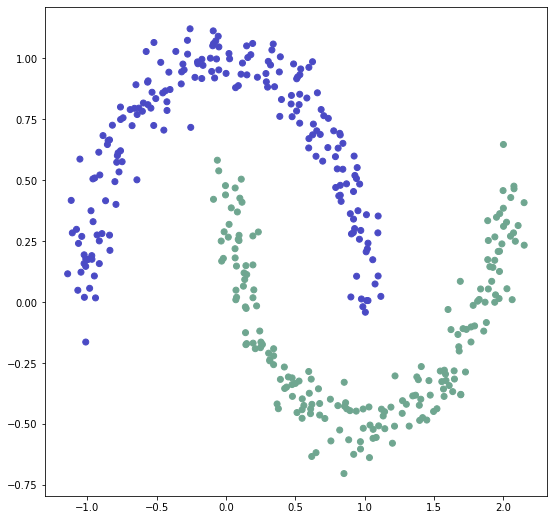

In [10]:
dbscan = DBScan(eps=0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [11]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """
        
        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры 
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек, 
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        
        def average(A, B):
            if len(A) < len(B): 
                A, B = B, A

            sum = 0
            for b in B:
                sum +=np.linalg.norm(A-b, axis=1).sum()

            return sum / (len(A) * len(B))

        def single(A, B):
            if len(A) < len(B): 
                A, B = B, A

            min_ = np.inf
            for b in B:    
                m = np.linalg.norm(A-b, axis=1).min()
                if m < min_:
                    min_ = m

            return min_

        def complete(A, B):
            if len(A) < len(B): 
                A, B = B, A

            max_ = 0
            for b in B:    
                m = np.linalg.norm(A-b, axis=1).max()
                if m > max_:
                    max_ = m

            return max_        
        
        self.n_clusters = n_clusters
        if linkage == 'average':
            self.get_dist = average
        elif linkage == 'single':
            self.get_dist = single
        else:
            self.get_dist = complete
    
    def fit_predict(self, X: np.array, y = None) -> np.array:
        """
        Кластеризует элементы из X, 
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        
        X_class = np.arange(len(X))
        dists = np.full((len(X), len(X)), np.inf)

        for class_1 in np.unique(X_class):
            for class_2 in np.unique(X_class):
                if class_1 == class_2 or dists[class_2, class_1] != np.inf:
                    continue
                dist = self.get_dist(X[X_class==class_1], X[X_class==class_2])
                dists[class_1, class_2] = dist
                dists[class_2, class_1] = dist   

        while len(np.unique(X_class)) > self.n_clusters:
            class_1, class_2 = np.unravel_index(np.argmin(dists), dists.shape)

            X_class[X_class==class_2] = class_1

            dists[class_2, :] = np.inf
            dists[:, class_2] = np.inf

            for class_ in np.unique(X_class):
                if class_ == class_1:
                    continue
                dist = self.get_dist(X[X_class==class_1], X[X_class==class_])
                dists[class_1, class_] = dist
                dists[class_, class_1] = dist
        
        for i in range(self.n_clusters):
            X_class[X_class==np.unique(X_class)[i]] = i
        
        return X_class 

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

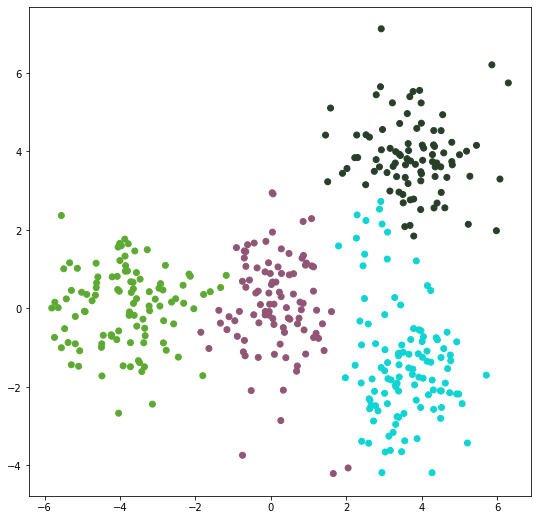

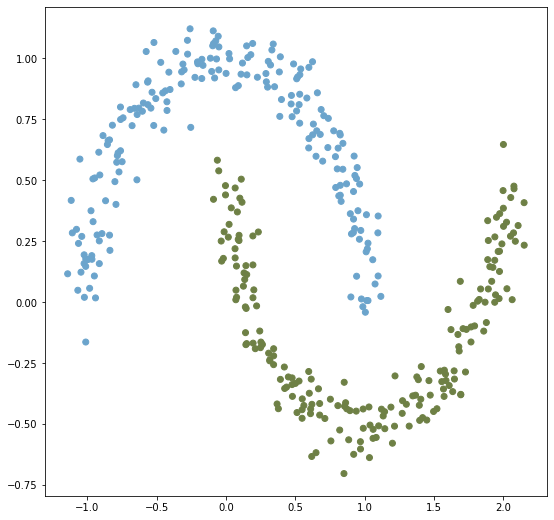

In [12]:
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [13]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
    
    return img

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    
    img = image * 255
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cv2.imwrite(path, img)

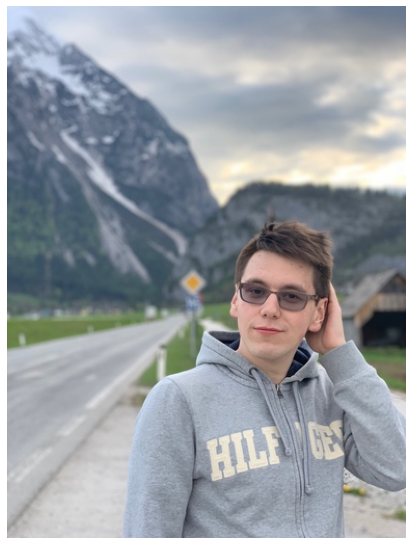

In [14]:
show_image(read_image("./image.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [15]:
def clusterize_image(image, **kwargs):
    kmeans = KMeans(n_clusters=10, init='k-means++')
    kmeans.fit(X=image.reshape(-1,3))
    
    cluster_colors = kmeans.centroids # color of each cluster
    clusters = kmeans.predict(image.reshape(-1,3)) # Cluster labels for each pixel in flattened image
    recolored = np.copy(image.reshape(-1,3)) # Image with pixel colors assigned to corresponding cluster colors
    for i in range(kmeans.n_clusters):
        recolored[clusters == i] = cluster_colors[i]
    clusters_statistics(image.reshape(-1, 3), cluster_colors, clusters) # Very slow (:
    return recolored.reshape(image.shape)

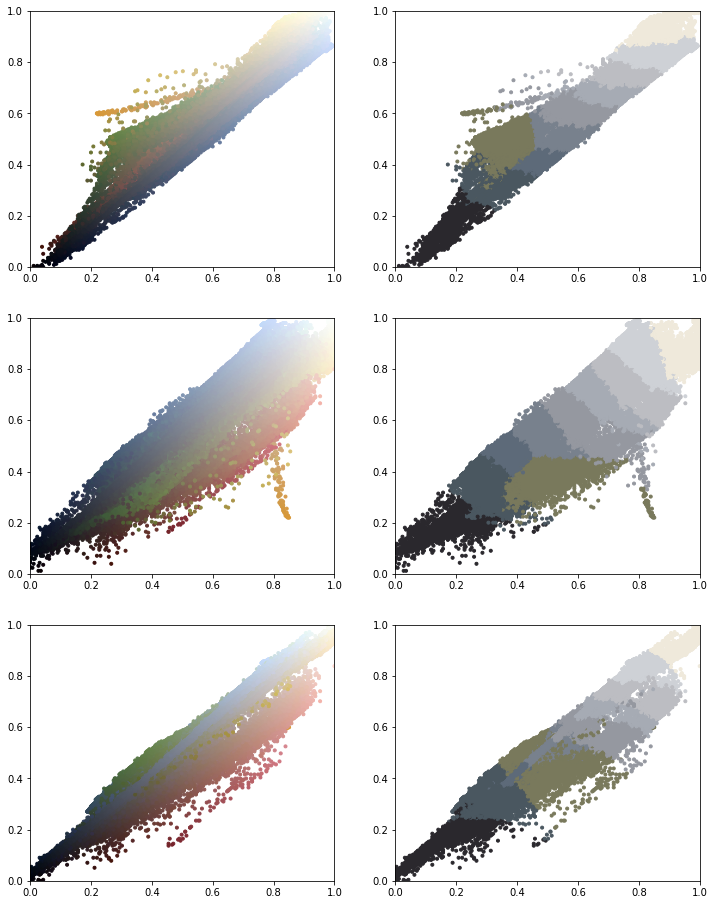

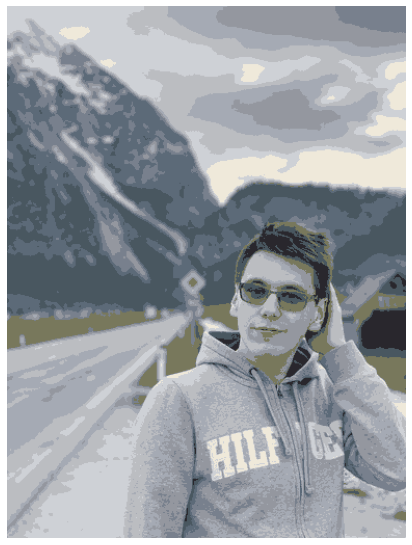

In [16]:
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")